In [29]:
import agentpy as ap
import numpy as np
import seaborn as sns
import pandas as pd
import random
import matplotlib.pyplot as plt

In [30]:
def gini(x):
    """ Calcular el Coeficiente de Gini """
    x = np.array(x)
    mad = np.abs(np.subtract.outer(x, x)).mean()  
    rmad = mad / np.mean(x)  
    return 0.5 * rmad

class BaseWealthAgent(ap.Agent):
    """ Agente base con riqueza """
    def setup(self):
        self.wealth = 1
        self.strategy_name = "Base"
    
    def wealth_transfer(self):
        pass

Hybrid Agent
The HybridAgent class combines the best aspects of BDI (Belief-Desire-Intention), RiskTaker, and DeductiveReasoning strategies. It maintains beliefs about its state, desires to achieve goals, and intentions to perform actions. The agent exhibits risk-taking behavior by transferring wealth when it has sufficient resources and uses deductive reasoning to determine the best actions based on its beliefs and the environment. This hybrid approach enables the agent to make informed and strategic decisions, optimizing wealth transfer within the simulation.

In [31]:
class HybridAgent(BaseWealthAgent):
    def setup(self):
        super().setup()
        self.strategy_name = "Hybrid"
        self.wealth = 3
        self.beliefs = {'wealth': self.wealth, 'partner': None}
        self.desires = {'save_wealth': True}
        self.intentions = []
        self.actions = [self.wealth_transfer]
        self.rules = [self.rule_1]

    def update_beliefs(self):
        self.beliefs['wealth'] = self.wealth

    def generate_options(self):
        options = []
        if self.beliefs['wealth'] > 2:
            options.append('transfer')
        return options

    def filter_options(self, options):
        if 'transfer' in options:
            self.intentions = ['transfer']
        else:
            self.intentions = []

    def create_plan(self):
        if 'transfer' in self.intentions:
            partner = list(self.model.agents.random(n=1))[0]
            return lambda: self.transfer_wealth(partner)
        return lambda: None

    def transfer_wealth(self, partner):
        transfer = min(self.wealth - 1, 3)
        partner.wealth += transfer
        self.wealth -= transfer

    def see(self, agents):
        per = agents.random()
        self.beliefs['partner'] = per

    def next(self):
        for act in self.actions:
            for rule in self.rules:
                if rule(act):
                    return act
        return None

    def action(self, act):
        if act is not None:
            act()

    def step(self):
        self.update_beliefs()
        options = self.generate_options()
        self.filter_options(options)
        plan = self.create_plan()
        plan()
        self.see(self.model.agents)
        a = self.next()
        self.action(a)

    def rule_1(self, act):
        rule_validation = [False, False, False]
        if self.wealth > 0:
            rule_validation[0] = True
        if self.beliefs["partner"] is not None:
            rule_validation[1] = True
        if act == self.wealth_transfer:
            rule_validation[2] = True
        return all(rule_validation)

    def wealth_transfer(self):
        if self.beliefs['partner'] is not None:
            self.beliefs['partner'].wealth += 1
            self.wealth -= 1


In [32]:
class BDIAgent(BaseWealthAgent):
    def setup(self):
        super().setup()
        self.strategy_name = "BDI"
        self.wealth = 2
        self.beliefs = {'wealth': self.wealth}
        self.desires = {'save_wealth': True}
        self.intentions = []

    def update_beliefs(self):
        # Update beliefs based on current wealth
        self.beliefs['wealth'] = self.wealth

    def generate_options(self):
        # Generate possible options based on beliefs and desires
        options = []
        if self.beliefs['wealth'] > 2:
            options.append('transfer')
        return options

    def filter_options(self, options):
        # Filter options to form intentions
        if 'transfer' in options:
            self.intentions = ['transfer']
        else:
            self.intentions = []

    def create_plan(self):
        # Create a plan based on intentions
        if 'transfer' in self.intentions:
            partner = list(self.model.agents.random(n=1))[0]
            return lambda: self.transfer_wealth(partner)
        return lambda: None

    def transfer_wealth(self, partner):
        partner.wealth += 1
        self.wealth -= 1

    def wealth_transfer(self):
        self.update_beliefs()
        options = self.generate_options()
        self.filter_options(options)
        plan = self.create_plan()
        plan()

In [33]:
class RiskTakingAgent(BaseWealthAgent):
    def setup(self):
        super().setup()
        self.strategy_name = "RiskTaker"
        self.wealth = 4  
    
    def wealth_transfer(self):
        if self.wealth > 2:
            partner = list(self.model.agents.random(n=1))[0]
            transfer = min(self.wealth - 1, 3)  
            partner.wealth += transfer
            self.wealth -= transfer

In [34]:
class DeductiveReasoningAgent(BaseWealthAgent):
    def setup(self):
        super().setup()
        self.strategy_name = "DeductiveReasoning"
        self.beliefs = {'partner': None}
        self.actions = [self.wealth_transfer]
        self.rules = [self.rule_1]

    def see(self, agents):
        per = agents.random()
        self.beliefs['partner'] = per

    def next(self):
        for act in self.actions:
            for rule in self.rules:
                if rule(act):
                    return act
        return None

    def action(self, act):
        if act is not None:
            act()

    def step(self):
        self.see(self.model.agents)
        a = self.next()
        self.action(a)

    def rule_1(self, act):
        rule_validation = [False, False, False]
        if self.wealth > 0:
            rule_validation[0] = True
        if self.beliefs["partner"] is not None:
            rule_validation[1] = True
        if act == self.wealth_transfer:
            rule_validation[2] = True
        return all(rule_validation)

    def wealth_transfer(self):
        if self.beliefs['partner'] is not None:
            self.beliefs['partner'].wealth += 1
            self.wealth -= 1

In [35]:
class WealthModel(ap.Model):
    """ Un modelo de transferencias de riqueza entre diferentes estrategias de agentes """
    
    def setup(self):
        # Crear una lista de agentes basada en los parámetros del modelo
        self.agents = ap.AgentList(self, self.p.agents['BDI'], BDIAgent) + \
                      ap.AgentList(self, self.p.agents['RiskTaker'], RiskTakingAgent) + \
                      ap.AgentList(self, self.p.agents['Hybrid'], HybridAgent) + \
                      ap.AgentList(self, self.p.agents['DeductiveReasoning'], DeductiveReasoningAgent)

    def step(self):
        # Cada agente realiza una transferencia de riqueza
        self.agents.wealth_transfer()

    def update(self):
        # Calcular el Coeficiente de Gini para la distribución de riqueza actual
        wealths = [agent.wealth for agent in self.agents]
        self.record('Gini Coefficient', gini(wealths))

    def end(self):
        # Registrar la riqueza final de cada agente
        self.agents.record('wealth')

In [36]:
# Parámetros del Modelo
parameters = {
    'agents': {
        'BDI': 10,
        'RiskTaker': 10,
        'DeductiveReasoning': 10,
        'Hybrid': 10,
    },
    'steps': 100,
    'seed': 42,
}


In [37]:
# Correr el Modelo
model = WealthModel(parameters)
results = model.run()


Completed: 100 steps
Run time: 0:00:00.034253
Simulation finished


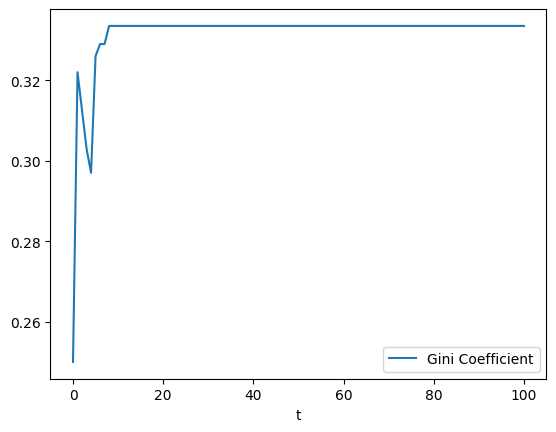

In [38]:
# Visualización de Resultados
data = results.variables.WealthModel
ax = data.plot()

Evolución de la Desigualdad Económica en el Modelo de Distribución de Riqueza Multi-Agente

Este gráfico muestra la evolución del coeficiente de Gini a lo largo de los 100 pasos de la simulación. El coeficiente de Gini mide la desigualdad de la riqueza (0 significa igualdad perfecta, 1 significa desigualdad perfecta). Del gráfico se observa:

El coeficiente comienza relativamente bajo (alrededor de 0.25)
Hay un pico inicial y volatilidad en los primeros pasos (alrededor del paso 20)
El coeficiente se estabiliza en alrededor de 0.32, indicando un nivel moderado de desigualdad
La línea relativamente estable después de la volatilidad inicial sugiere que el sistema alcanza un estado de equilibrio

In [39]:
# Extraer datos de riqueza y tipo de agente después de la simulación
agent_data = [(agent.strategy_name, agent.wealth) for agent in model.agents]
df = pd.DataFrame(agent_data, columns=["Agent Type", "Wealth"])


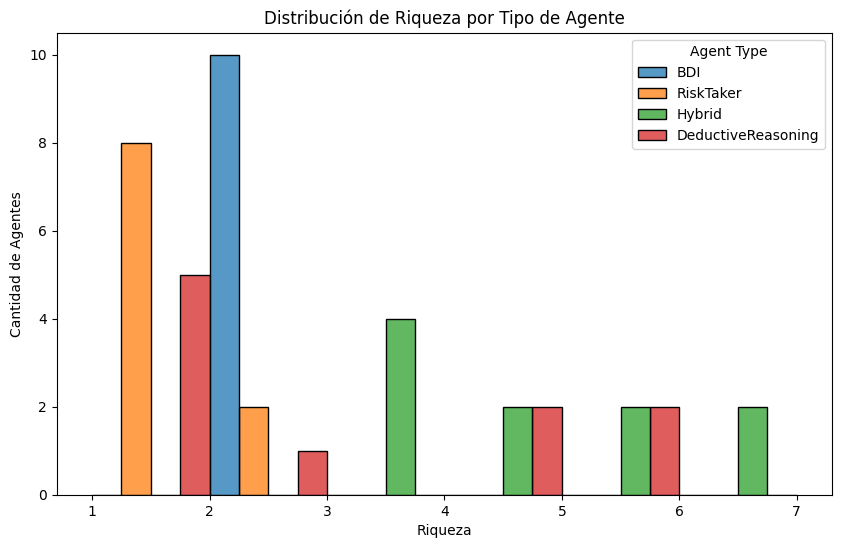

In [40]:
# Crear histograma de la distribución de riqueza por tipo de agente
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="Wealth", hue="Agent Type", multiple="dodge", binwidth=1)
plt.title("Distribución de Riqueza por Tipo de Agente")
plt.xlabel("Riqueza")
plt.ylabel("Cantidad de Agentes")
plt.show()


Comparación de Estrategias de Agentes en la Acumulación de Riqueza

Este histograma muestra cómo se distribuye la riqueza entre los diferentes tipos de agentes (BDI, RiskTaker, Hybrid y DeductiveReasoning). Observaciones notables:

Agentes RiskTaker (Naranja):

Muestran una distribución bimodal
Algunos tienen baja riqueza (1-2 unidades)
Otros mantienen niveles de riqueza más altos
Esto se alinea con su estrategia de toma de riesgos
Agentes BDI (Azul):

Tienen la mayor concentración en el nivel de riqueza 2
Muestran una distribución de riqueza más conservadora
Esto coincide con su enfoque de toma de decisiones más cauteloso
Agentes Hybrid (Rojo):

Muestran una dispersión a través de diferentes niveles de riqueza
Tienen algunos agentes en niveles de riqueza bajos y medios
Demuestra su enfoque de estrategia mixta
Agentes DeductiveReasoning (Verde):

Más uniformemente distribuidos en niveles de riqueza de 3 a 7
Muestran una presencia constante en niveles de riqueza más altos
Sugiere que su enfoque de razonamiento ayuda a mantener la riqueza